In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import anndata as ad
import scanpy as sc

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from umap import UMAP

from scroutines import powerplots
import time

import importlib
importlib.reload(powerplots)
from scroutines import basicu
from scroutines.miscu import is_in_polygon

import utils_merfish

In [2]:
np.random.seed(0)

from merfish_datasets import merfish_datasets
directories = merfish_datasets
print(merfish_datasets)

{'P14NR_ant': 'merfish_06142023/ant/region0', 'P28NR_ant': 'merfish_06142023/ant/region1', 'P14NR_pos': 'merfish_06142023/pos/region0', 'P28NR_pos': 'merfish_06142023/pos/region1', 'P21NR_ant': 'merfish_20231114/region0', 'P21DR_ant': 'merfish_20231114/region2', 'P28DR_ant': 'merfish_20231114/region1', 'P21NR_pos': 'merfish_20231120/region0', 'P21DR_pos': 'merfish_20231120/region1', 'P28DR_pos': 'merfish_20231120/region2'}


In [3]:
name = 'P28NR_ant'
dirc = directories[name]

full_dirc = f'/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/{dirc}/'
f_main    = f'/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/organized/{name}_ctxglut_240411.h5ad'
f1   = full_dirc + 'detected_transcripts.csv'
# f2   = full_dirc + 'cell_metadata.csv'
fout = full_dirc + 'detected_transcripts_v1l23.csv'

In [4]:
adata = ad.read(f_main)
bound_l, bound_r, bound_d = adata.uns['bound_lrd']
cond = np.all([
    adata.obs['width'] > bound_l, 
    adata.obs['width'] < bound_r, 
    adata.obs['depth'] < bound_d, 
], axis=0)
adatasub = adata[cond]

rotation_angle = adata.uns['rotation']
ref_line = np.array(adata.uns['ref_line'])

adatasub

View of AnnData object with n_obs × n_vars = 1535 × 500
    obs: 'EntityID', 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'PolyT_raw', 'PolyT_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'gncov', 'gnnum', 'fpcov', 'x', 'y', 'depth', 'width', 'inside_v1l23'
    uns: 'bound_lrd', 'ref_line', 'rotation'
    obsm: 'blanks', 'pca'
    layers: 'norm'

In [5]:
# get FOVs
fovs = np.unique(adatasub.obs['fov'])
fovs.shape, fovs

((18,),
 array([2262, 2263, 2321, 2322, 2323, 2324, 2325, 2326, 2327, 2328, 2329,
        2377, 2378, 2379, 2380, 2381, 2382, 2383]))

# get transcripts in V1 L2/3

In [6]:
# go over all tranascripts - select only those that are within these FOVs
chunks = pd.read_csv(f1, chunksize=1000000)
dfsubs = []

ti = time.time()
for i, chunk in enumerate(chunks):
    print(i, time.time()-ti)
    dfsub = chunk[chunk['fov'].isin(fovs)]
    if len(dfsub) > 0:
        print(len(dfsub))
        dfsubs.append(dfsub)

0 1.8836414813995361
1 3.4972007274627686
2 5.120158672332764
3 6.697817087173462
4 8.301180601119995
5 10.208266496658325
6 12.037124872207642
7 13.558788061141968
8 15.192915201187134
9 17.15046977996826
10 18.62717080116272
11 20.62864351272583
12 22.409794330596924
13 23.896220684051514
14 25.885565042495728
15 27.44118046760559
16 28.952926635742188
17 30.39382004737854
18 32.18145728111267
19 33.745786905288696
20 35.52980923652649
21 37.06456255912781
22 39.425100564956665
23 41.29102158546448
24 42.97485637664795
25 44.60872149467468
26 46.246315002441406
27 47.91075301170349
28 49.59994387626648
29 51.38868713378906
30 53.01072835922241
31 54.900426149368286
32 56.85159349441528
33 58.570677757263184
34 60.238659143447876
35 61.843189001083374
36 63.46937608718872
37 65.08115458488464
38 66.74050974845886
39 69.0428318977356
40 71.03293561935425
41 72.8199827671051
42 74.54673600196838
43 76.27216625213623
44 77.79970979690552
45 79.39498853683472
46 81.0316231250763
47 82.378

In [7]:
df_v1l23 = pd.concat(dfsubs)
df_v1l23

,Unnamed: 0,barcode_id,global_x,global_y,global_z,x,y,fov,gene,transcript_id,cell_id
84789949,18,0,12088.416,7427.0527,0.0,512.75920,263.59180,2262,Cdh4,ENSMUST00000000314,2595481503174100051
84789950,19,0,12150.295,7427.9390,0.0,1085.70690,271.79623,2262,Cdh4,ENSMUST00000000314,2595481503174100082
84789951,24,0,12223.335,7431.5320,0.0,1762.00820,305.06714,2262,Cdh4,ENSMUST00000000314,-1
84789952,39,0,12043.761,7450.2640,0.0,99.28781,478.51013,2262,Cdh4,ENSMUST00000000314,-1
84789953,45,0,12084.694,7463.9487,0.0,478.30072,605.22156,2262,Cdh4,ENSMUST00000000314,2595481503229100018
...,...,...,...,...,...,...,...,...,...,...,...
93804543,132,531,12839.422,6446.9146,6.0,119.35749,575.00000,2383,Blank-32,Blank-32,-1
93804544,197,531,12851.047,6504.1543,6.0,227.00000,1105.00000,2383,Blank-32,Blank-32,2595481502795100023
93804545,204,531,12873.354,6510.2207,6.0,433.53986,1161.16980,2383,Blank-32,Blank-32,2595481502795100025
93804546,98,532,12843.875,6500.3105,6.0,160.59010,1069.40990,2383,Blank-33,Blank-33,2595481502795100023


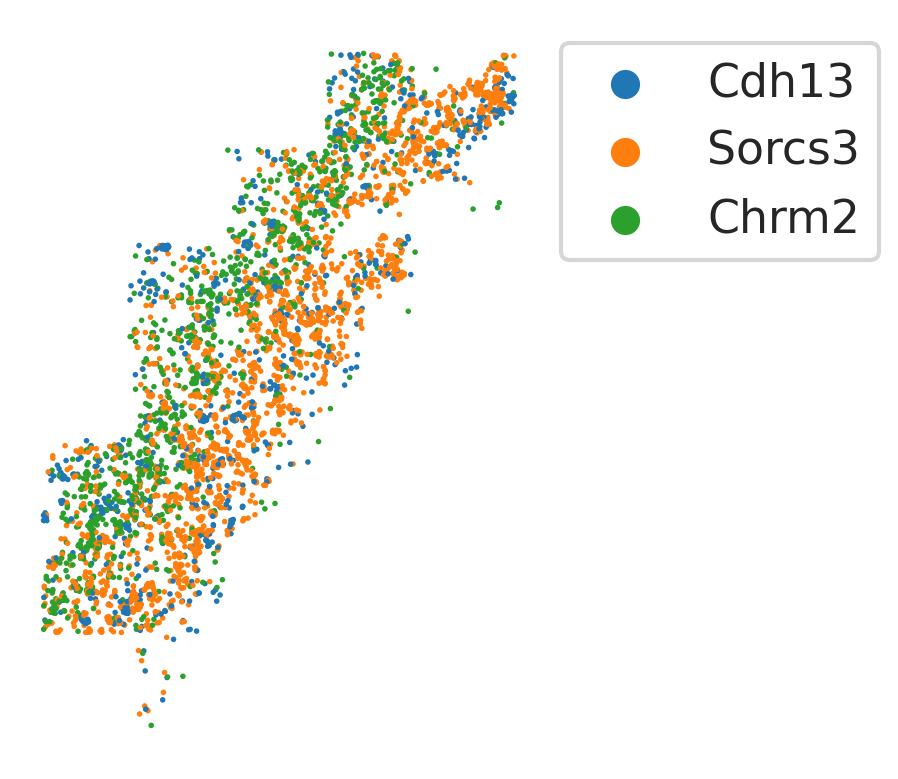

In [8]:
# check results
query_genes = ['Cdh13', 'Sorcs3', 'Chrm2']

abc = df_v1l23[df_v1l23['gene'].isin(query_genes)]  
fig, ax = plt.subplots()
sns.scatterplot(data=abc.sample(frac=1, replace=False), 
                x='global_x', y='global_y', hue='gene', hue_order=query_genes, 
                s=4, edgecolor='none', ax=ax, )
ax.set_aspect('equal')
ax.axis('off')
ax.legend(bbox_to_anchor=(1,1))
ax.invert_yaxis()

# rotate, calc depth and width, and viz

In [9]:
# reference line
ref_line_obj = utils_merfish.RefLineSegs(ref_line)

In [10]:
%%time
x = df_v1l23['global_x'].values
y = df_v1l23['global_y'].values
xr, yr = utils_merfish.rot2d(x, y, rotation_angle)
XY = np.vstack([xr, yr]).T 

df_v1l23['x'] = xr
df_v1l23['y'] = yr
df_v1l23['depth'] = ref_line_obj.ndist_to_qps(XY)
df_v1l23['width'] = ref_line_obj.tdist_to_qps(XY)

cond_spots = np.all([
    df_v1l23['width'] > bound_l, 
    df_v1l23['width'] < bound_r, 
    df_v1l23['depth'] < bound_d, 
], axis=0)

df_v1l23 = df_v1l23[cond_spots]

CPU times: user 6.04 s, sys: 9.88 s, total: 15.9 s
Wall time: 16.1 s


In [11]:
abc = df_v1l23[df_v1l23['gene'].isin(query_genes)]  

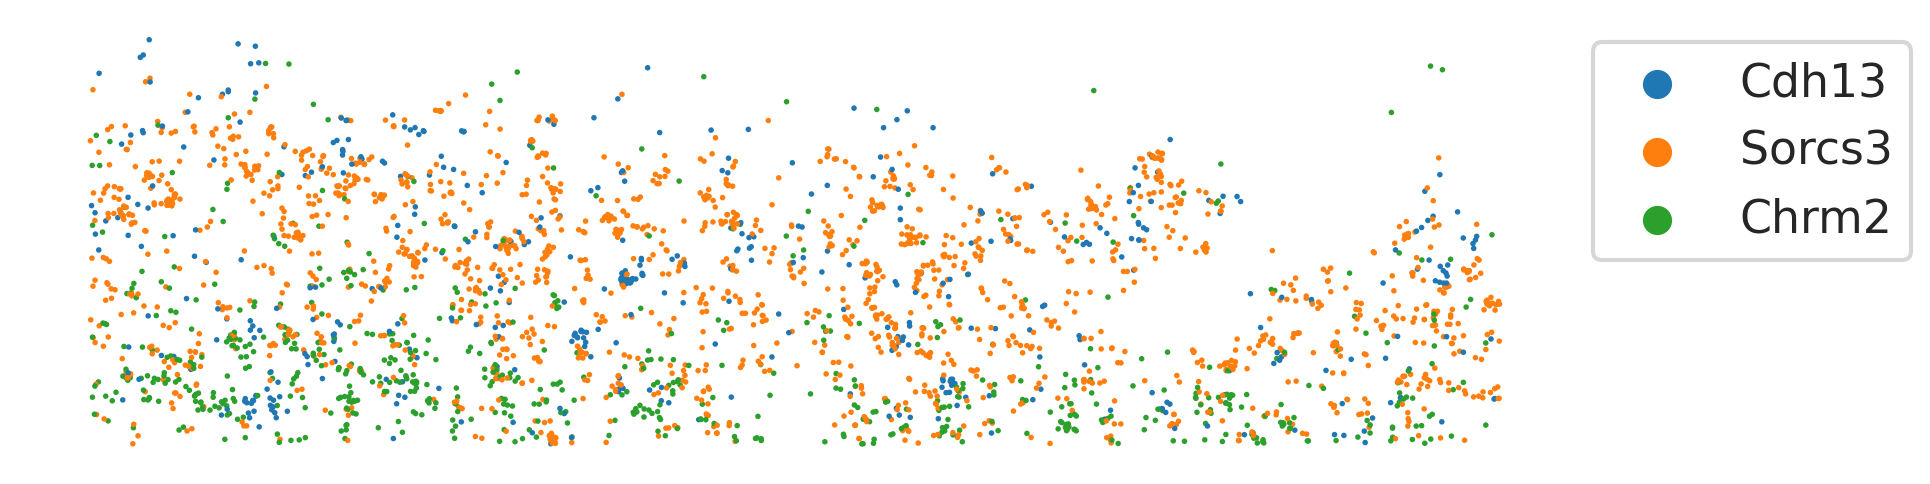

In [12]:
fig, ax = plt.subplots(1,1,figsize=(10,3))
sns.scatterplot(data=abc.sample(frac=1, replace=False), 
                x='width', y='depth', hue='gene', hue_order=query_genes, 
                s=4, edgecolor='none', ax=ax, )
ax.set_aspect('equal')
ax.axis('off')
ax.legend(bbox_to_anchor=(1,1))
ax.invert_yaxis()

# Save results

In [13]:
df_v1l23

,Unnamed: 0,barcode_id,global_x,global_y,global_z,x,y,fov,gene,transcript_id,cell_id,depth,width
84789949,18,0,12088.4160,7427.0527,0.0,-7427.0527,12088.4160,2262,Cdh4,ENSMUST00000000314,2595481503174100051,386.398394,3029.964945
84789950,19,0,12150.2950,7427.9390,0.0,-7427.9390,12150.2950,2262,Cdh4,ENSMUST00000000314,2595481503174100082,336.180749,3066.131010
84789951,24,0,12223.3350,7431.5320,0.0,-7431.5320,12223.3350,2262,Cdh4,ENSMUST00000000314,-1,275.387611,3106.775144
84789954,46,0,12183.8470,7464.5850,0.0,-7464.5850,12183.8470,2262,Cdh4,ENSMUST00000000314,-1,287.398400,3056.699762
84789955,52,0,12153.1860,7470.8125,0.0,-7470.8125,12153.1860,2262,Cdh4,ENSMUST00000000314,2595481503229100027,308.308104,3033.426109
...,...,...,...,...,...,...,...,...,...,...,...,...,...
93804487,125,462,12877.2910,6590.8450,6.0,-6590.8450,12877.2910,2383,Cacng8,ENSMUST00000182222,2595481502850100137,251.275333,4171.590471
93804488,99,464,12836.7910,6576.9043,6.0,-6576.9043,12836.7910,2383,Unc13c,ENSMUST00000184666,2595481502849100096,292.105410,4158.648371
93804495,109,468,12839.7520,6546.1990,6.0,-6546.1990,12839.7520,2383,Kirrel3,ENSMUST00000188933,-1,308.027009,4185.069681
93804540,179,526,12864.9795,6563.0146,6.0,-6563.0146,12864.9795,2383,Blank-27,Blank-27,2595481502850100015,277.747556,4186.601319


In [14]:
df_v1l23.to_csv(fout, header=True, index=False)
!head $fout

Unnamed: 0,barcode_id,global_x,global_y,global_z,x,y,fov,gene,transcript_id,cell_id,depth,width
18,0,12088.416,7427.0527,0.0,-7427.052699999999,12088.416,2262,Cdh4,ENSMUST00000000314,2595481503174100051,386.3983938425997,3029.964944687146
19,0,12150.295,7427.939,0.0,-7427.938999999999,12150.295,2262,Cdh4,ENSMUST00000000314,2595481503174100082,336.18074863242725,3066.13100997265
24,0,12223.335,7431.532,0.0,-7431.531999999999,12223.335,2262,Cdh4,ENSMUST00000000314,-1,275.3876106896125,3106.775143965955
46,0,12183.847,7464.585,0.0,-7464.584999999999,12183.847,2262,Cdh4,ENSMUST00000000314,-1,287.39839959911336,3056.699761763007
52,0,12153.186,7470.8125,0.0,-7470.812499999999,12153.186,2262,Cdh4,ENSMUST00000000314,2595481503229100027,308.30810417449635,3033.4261085942367
54,0,12182.57,7473.537,0.0,-7473.536999999999,12182.57,2262,Cdh4,ENSMUST00000000314,-1,283.088756478177,3048.75017000178
74,0,12224.975,7494.217,0.0,-7494.216999999999,12224.975,2262,Cdh4,ENSMUST00000000314,-1,236.712553358